In [486]:
import numpy as np
import os
import dask.array as da
import glob
from dask import array as da
import os
import numpy as np
def read_im(path, return_pos=False):
    dirname = os.path.dirname(path)
    fov = os.path.basename(path).split('_')[-1].split('.')[0]
    file_ = os.path.join(dirname, fov, 'data')
    
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    if r'.fast.zarr' in txt:
        image = da.from_zarr(path)
        ncols = 5
        image = image.reshape([-1,ncols,image.shape[-2],image.shape[-1]])
        image = image.swapaxes(0,1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
            image = da.array([image[1]+image[2],image[3],image[4],image[0]])
    else:
        image = da.from_zarr(file_)[1:]
    
        shape = image.shape
        tag = '<z_offsets type="string">'
        zstack = txt.split(tag)[-1].split('</')[0]
    
        nchannels = int(zstack.split(':')[-1])
        nzs = (shape[0] // nchannels) * nchannels
        image = image[:nzs].reshape([shape[0] // nchannels, nchannels, shape[-2], shape[-1]])
        image = image.swapaxes(0, 1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
    
    if return_pos:
        return image, x, y
    return image
    
def get_pos(path):
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    return x,y

def get_im_from_Xh(Xh,resc=5):
    X = np.round(Xh[:,:3]/resc).astype(int)
    sz = np.max(X,axis=0)
    imf = np.zeros(sz+1,dtype=np.float32)
    imf[tuple(X.T)]=1
    return imf
from scipy.spatial import KDTree
def get_Xtzxy(X,X_ref,tzxy0,resc,target=3):
    tzxy = tzxy0
    Npts =0
    for dist_th in np.linspace(resc,target,5):
        XT = X-tzxy
        ds,inds = KDTree(X_ref).query(XT,workers=20)
        keep = ds<dist_th
        X_ref_ = X_ref[inds[keep]]
        X_ = X[keep]
        tzxy = np.mean(X_-X_ref_,axis=0)
        #print(tzxy)
        Npts = np.sum(keep)
    return tzxy,Npts
def get_best_translation_points(X,X_ref,resc=10,target=1,constr=None,return_counts=False):
    XFF = np.concatenate([X,X_ref])
    X = X-np.min(XFF,axis=0)
    X_ref = X_ref-np.min(XFF,axis=0)
    if constr is not None:
        Xm = np.max([np.min(X,axis=0),np.min(X_ref,axis=0)],axis=0)-constr
        XM = np.min([np.max(X,axis=0),np.max(X_ref,axis=0)],axis=0)+constr
        keep = np.all((X<=XM)&(X>=Xm),axis=-1)
        X = X[keep]
        keep = np.all((X_ref<=XM)&(X_ref>=Xm),axis=-1)
        X_ref = X_ref[keep]
        XFF = np.concatenate([X,X_ref])
        X = X-np.min(XFF,axis=0)
        X_ref = X_ref-np.min(XFF,axis=0)
    
    im = get_im_from_Xh(X,resc=resc)
    im_ref = get_im_from_Xh(X_ref,resc=resc)
    
    from scipy.signal import fftconvolve
    im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
    #plt.imshow(np.max(im_cor,0))
    tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1
    tzxy = tzxy*resc
    Npts=0
    tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,target=target)
    if return_counts:
        return tzxy,Npts
    return tzxy
def calc_color_matrix(x,y,order=2):
    """This gives a quadratic color transformation (in matrix form)
    x is Nx3 vector of positions in the reference channel (typically cy5)
    y is the Nx3 vector of positions in another channel (i.e. cy7)
    return m_ a 3x7 matrix which when multipled with x,x**2,1 returns y-x
    This m_ is indended to be used with apply_colorcor
    """ 
    x_ = np.array(y)# ref zxy
    y_ = np.array(x)-x_# dif zxy
    # get a list of exponents
    exps = []
    for p in range(order+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    # construct A matrix
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    m_ = [np.linalg.lstsq(A, y_[:,iy])[0] for iy in range(len(x_[0]))]
    m_=np.array(m_)
    return m_
def apply_colorcor(x,m=None):
    """This applies chromatic abberation correction to order 2
    x is a Nx3 vector of positions (typically 750(-->647))
    m is a matrix computed by function calc_color_matrix
    y is the corrected vector in another channel"""
    if m is None:
        return x
    exps = []
    order_max=10
    for p in range(order_max+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    #find the order
    mx,my = m.shape
    order = int((my-1)/mx)
    assert(my<len(exps))
    x_ = np.array(x)
    # construct A matrix
    exps = exps[:my]
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    diff = [np.dot(A,m_) for m_ in m]
    return x_+np.array(diff).T
def apply_transf(X1,Trans,resc = (4,10,10)):
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    return X1+Trans[tuple(X1R.T)]
def calc_trasnf(X2,X1,szM = (40,2800,2800),resc = (4,10,10)):
    Trans = np.zeros(list(np.array(szM)//resc)+[3])
    Neles = np.zeros(list(np.array(szM)//resc))
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    np.add.at(Trans,tuple(X1R.T),X2-X1)
    np.add.at(Neles,tuple(X1R.T),1)
    TransF = Trans/Neles[...,np.newaxis]
    
    Xbad = np.array(np.where(np.isnan(TransF[...,0]))).T
    Xgood= np.array(np.where(~np.isnan(TransF[...,0]))).T
    dd,ii = KDTree(Xgood).query(Xbad)
    TransF[tuple(Xbad.T)]=TransF[tuple(Xgood[ii].T)]
    return TransF
def get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=5,th=0):
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0]),0,0
    if (len(obj_Xh_plus)>0) and (len(obj_ref_Xh_plus)>0):
        X = obj_Xh_plus[obj_Xh_plus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_plus[obj_ref_Xh_plus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_plus,N_plus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if (len(obj_Xh_minus)>0) and (len(obj_ref_Xh_minus)>0):
        X = obj_Xh_minus[obj_Xh_minus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_minus[obj_ref_Xh_minus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_minus,N_minus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if np.max(np.abs(tzxy_minus-tzxy_plus))<=2:
        tzxyf = -(tzxy_plus*N_plus+tzxy_minus*N_minus)/(N_plus+N_minus)
    else:
        tzxyf = -[tzxy_plus,tzxy_minus][np.argmax([N_plus,N_minus])]
    return [tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus]
import numpy as np

def calculate_best_rotation(P, Q):
    """
    P and Q are N x 3 matrices of points.
    Returns the 3x3 rotation matrix R.
    """
    # 1. Center the points
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    Pc = P - centroid_P
    Qc = Q - centroid_Q

    # 2. Compute covariance matrix
    H = Pc.T @ Qc

    # 3. SVD
    U, S, Vt = np.linalg.svd(H)

    # 4. Compute rotation
    R = Vt.T @ U.T

    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    return R

def get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0,MA=None,return_rotation=False):
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    fl_feats_ref = rf'{save_folder_ref}\{fov}--{htagref}--dapiFeatures.npz'
    obj_Xh_plus,obj_Xh_minus = np.load(fl_feats)['Xh_plus'],np.load(fl_feats)['Xh_minus']
    obj_ref_Xh_plus,obj_ref_Xh_minus = np.load(fl_feats_ref)['Xh_plus'],np.load(fl_feats_ref)['Xh_minus']
    obj_ref_Xh_plus[:,:3] = apply_colorcor(obj_ref_Xh_plus[:,:3],MA)
    obj_ref_Xh_minus[:,:3] = apply_colorcor(obj_ref_Xh_minus[:,:3],MA)
    obj_Xh_plus[:,:3] = apply_colorcor(obj_Xh_plus[:,:3],MA)
    obj_Xh_minus[:,:3] = apply_colorcor(obj_Xh_minus[:,:3],MA)
    
    
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=resc,th=th)
    if return_rotation: 
        X1,X2 = obj_Xh_plus[:,:3]+tzxyf,obj_ref_Xh_plus[:,:3]
        dd,ii = KDTree(X1).query(X2)
        
        R = calculate_best_rotation(X1[ii[dd<5]], X2[dd<5])
        
        return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus,R
    return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus
import torch
def get_icodesV3(dec,nmin_bits=3,iH=-3,save=False,make_unique=False):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64)
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__))
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis]
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    dec.dist_best = dists_best_.numpy()
    if make_unique:
        indexMols_,rinvMols = get_unique_ordered(indexMols_)
        icodesN = icodesN[rinvMols]
        dec.dist_best = dists_best_[rinvMols].numpy()
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    if save:
        np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)
def get_XH_singleFOV(self,fov,set_,ncols=3,nbits=16,th_h=0,tag_keep='MER',medH_fl=None,color_fl=None):
    self.set_ = set_
    save_folder = self.save_folder
    drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
    if os.path.exists(drift_fl):
        drifts,all_flds,fov,fl_ref = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov,self.fl_ref = drifts,all_flds,fov,fl_ref
    else:
        drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
        drifts,all_flds,fov = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov = drifts,all_flds,fov

    XH = []
    for iH in tqdm(np.arange(len(all_flds))):
        fld = all_flds[iH]
        if tag_keep in os.path.basename(fld):
            for icol in range(ncols):
                tag = os.path.basename(fld)
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npy.npz'
                if not os.path.exists(save_fl):save_fl = save_fl.replace('.npy','')
                Xh = np.load(save_fl,allow_pickle=True)['Xh']
                tzxy = drifts[iH][0]
                        
                ih = get_iH(fld) # get bit
                is_low = 'low' in tag
                bit = (ih-1)*ncols+icol
                print(Xh.shape)
                if len(Xh.shape):
                    if medH_fl is not None:
                        medHs = np.load(medH_fl)['medHs']
                        Xh[:,-1]=Xh[:,-1]/medHs[bit]
                if len(Xh.shape):
                    if len(Xh):
                        Xh = Xh[Xh[:,-1]>th_h]
                    if len(Xh):
                        
                        icolR = np.array([[icol,bit]]*len(Xh))

                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,[0,1,2]] = apply_colorcor(Xh[:,[0,1,2]],ms[icol])
                        Xh[:,:3]+=tzxy# drift correction
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.extend(XH_)
    self.XH = np.array(XH)
def get_fov(fl):
    return os.path.basename(fl).split('--')[0].replace('.zarr','')
def get_set(fov):
    return '_set'+fov.split('zscan')[-1].split('_')[0]
from scipy.spatial import KDTree
def get_intersV2(self,nmin_bits=3,dinstance_th=2):
    """Get an initial intersection of points and save in self.res"""

    XH = self.XH
    Xs = XH[:,:3]
    Ts = KDTree(Xs)
    res = Ts.query_ball_point(Xs,dinstance_th,workers=20)
    print("Calculating lengths of clusters...")
    lens = np.array(list(map(len,res)))
    Mlen = np.max(lens)
    print("Unfolding indexes...")
    res_unfolder = np.concatenate(res)
    
    self.res_unfolder=res_unfolder
    self.lens=lens
    
    lens =self.lens
    self.res_unfolder = self.res_unfolder[np.repeat(lens, lens)>=nmin_bits]
    self.lens = self.lens[lens>=nmin_bits]
def load_library(self,lib_fl = r'Z:\DCBBL1_3_2_2023\MERFISH_Analysis\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1):
        code_txt = np.array([ln.replace('\n','').split(',') for ln in open(lib_fl,'r') if ',' in ln])
        gns = code_txt[1:,0]
        code_01 = code_txt[1:,2:].astype(int)
        codes = np.array([np.where(cd)[0] for cd in code_01])
        codes_ = [list(np.sort(cd)) for cd in codes]
        nbits = np.max(codes)+1

        codes__ = codes_
        gns__ = list(gns)
        if nblanks>=0:
            ### get extrablanks
            from itertools import combinations
            X_codes = np.array((list(combinations(range(nbits),4))))
            X_code_01 = []
            for cd in X_codes:
                l_ = np.zeros(nbits)
                l_[cd] = 1
                X_code_01.append(l_)
            X_code_01 = np.array(X_code_01,dtype=int)
            from scipy.spatial.distance import cdist
            eblanks = np.where(np.min(cdist(code_01,X_code_01,metric='hamming'),0)>=4/float(nbits))[0]
            codes__ = codes_ + [list(e)for e in X_codes[eblanks]]
            gns__ = list(gns)+ ['blanke'+str(ign+1).zfill(4) for ign in range(len(eblanks))]
        
        bad_gns = np.array(['blank' in e for e in gns__])
        good_gns = np.where(~bad_gns)[0]
        bad_gns = np.where(bad_gns)[0]

        
        
        self.lib_fl = lib_fl ### name of coding library
        self.nbits = nbits ### number of bits
        self.gns_names = gns__  ### names of genes and blank codes
        self.bad_gns = bad_gns ### indices of the blank codes
        self.good_gns = good_gns ### indices of the good gene codes
        self.codes__ = codes__ ### final extended codes of form [bit1,bit2,bit3,bit4]
        self.codes_01 = code_01
        if nblanks>=0:
            self.codes_01 = np.concatenate([code_01,X_code_01[eblanks]],axis=0) ### final extended codes of form [0,1,0,0,1...]
        
        dic_bit_to_code = {}
        for icd,cd in enumerate(self.codes__): 
            for bit in cd:
                if bit not in dic_bit_to_code: dic_bit_to_code[bit]=[]
                dic_bit_to_code[bit].append(icd)
        self.dic_bit_to_code = dic_bit_to_code  ### a dictinary in which each bit is mapped to the inde of a code
def get_score(dec):
    H = np.nanmedian(dec.XH_pruned[...,-3],axis=1)
    n1bits = dec.XH_pruned.shape[1]
    from itertools import combinations
    combs = np.array(list(combinations(np.arange(n1bits),2)))
    X = dec.XH_pruned[:,:,:3]
    D = np.nanmean(np.linalg.norm(X[:,combs][:,:,0]-X[:,combs][:,:,1],axis=-1),axis=1)
    db = dec.dist_best
    score = np.array([H,-D,-db]).T
    #score = np.sort(score,axis=1)
    #score_ref = np.sort(score,axis=0)
    dec.score = score
    return score
def set_scoreA(dec):
    score_ref = dec.score_ref
    score = dec.score
    from scipy.spatial import KDTree
    scoreA = np.zeros(len(score))
    for iS in range(score.shape[-1]):
        dist_,inds_ = KDTree(score_ref[:,[iS]]).query(score[:,[iS]],workers=20)
        scoreA+=np.log((inds_+1))-np.log(len(score_ref))
    dec.scoreA = scoreA
def plot_multigenes(self,genes=['Gad1','Sox9'],colors=['r','g','b','m','c','y','w'],smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    icodesN,XH_pruned = self.icodesN,self.XH_pruned
    scoreA=self.scoreA
    th=self.th
    gns_names = list(self.gns_names)
    
    Xcms = np.nanmean(XH_pruned,axis=1)
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = icodesN[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        icode = gns_names.index(gene)
        is_code = icode==icodesf
        viewer.add_points(X[is_code][:,1:],size=size[is_code],face_color=color,name=gene,border_width=0)
        #viewer.layers[-1].visible=False
    return viewer
def plot_statistics(dec):
    if hasattr(dec,'im_segm_'):
        ncells = len(np.unique(dec.im_segm_))-1
    else:
        ncells = 1
    icds,ncds = np.unique(dec.icodesN[dec.scoreA>dec.th],return_counts=True)
    print([str(e)for e in dec.gns_names[icds[np.argsort(ncds)[::-1]]]][:30])
    good_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' not in gn.lower()]
    kp = np.in1d(icds,good_igns)
    ncds = ncds/ncells
    plt.figure()
    plt.xlabel('Genes')
    plt.plot(icds[kp],ncds[kp],label='genes')
    plt.plot(icds[~kp],ncds[~kp],label='blank')
    plt.ylabel('Number of molecules in the fov')
    plt.title(str(np.round(np.mean(ncds[~kp])/np.mean(ncds[kp]),3)))
    plt.yscale('log')
    plt.legend()
class dummy():
    def __init__(self):
        pass
def get_XH_full(dec,fov='Conv_zscan1__044',ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
               save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits','Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
               
               medH_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz',
                 color_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl',
               master_transf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy',
               dic_pos_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl'):
    dec.ncols = ncols
    dec.sz = sz
    dec.pix_size=pix_size
    dec.fov=fov
    set_ = get_set(fov)
    dec.set_ = set_
    MA = np.load(master_transf)
    
    dec.save_folders = save_folders
    htags = [f'H{iH+1}_MER{set_}' for iH in np.arange(9)]
    dic_pos = pickle.load(open(dic_pos_fl,'rb'))
    dec.dic_pos = dic_pos
    fovs = np.array(list(dic_pos.keys()))
    pos  = np.array([dic_pos[fv]for fv in fovs])
    ifov = list(fovs).index(fov)
    
    dists_pix = np.linalg.norm(np.abs((pos[ifov]-pos)/pix_size),axis=-1)
    allneigh = np.where(dists_pix<np.sqrt(2)*sz[-1]*1.25)[0]
    allneigh = allneigh[np.argsort(dists_pix[allneigh])]
    fovs_neigh = fovs[allneigh]
    dec.fovs = fovs
    dec.allneigh = allneigh
    dec.pos = pos
    XH = []
    for iH,htag in enumerate(tqdm(htags)):
        for icol in np.arange(ncols):
            Xhs,Xprev,posT_fovs= [],[],[]
            tfov=0
            for ifv in allneigh:
                fv = fovs[ifv]
                X_prev,Xh_prev = [],[]
                fit_fl_prev = ''
                save_folder_prev = ''
                for save_folder in save_folders:
                    fit_fl = save_folder+os.sep+fv+'--'+htag+'--col'+str(icol)+'__Xhfits.npz'
                    ### deal with 
                    
                    if os.path.exists(fit_fl):
                        Xh = np.load(fit_fl,allow_pickle=True)['Xh']
                        X = []
                        if len(Xh.shape):
                            if len(Xh)>0:
                                X = Xh[Xh[:,-4]>0.5][:,:3]
                        print(len(X),len(X_prev))
                        if len(X)<len(X_prev):
                            X = X_prev
                            Xh = Xh_prev
                            fit_fl_final = fit_fl_prev
                            SAVE_FOLDER = save_folder_prev
                        else:
                            X_prev = X
                            Xh_prev = Xh
                            fit_fl_final = fit_fl_prev = fit_fl
                            SAVE_FOLDER = save_folder_prev = save_folder
                print(fit_fl_final)
                if (iH==0) and (fov==fv):
                    save_folder_ref = SAVE_FOLDER
                    htagref = htag
                if (fov==fv):
                    save_folder_dapi = SAVE_FOLDER
                if len(Xh.shape):
                    if len(Xh)>0:
                        Xh = Xh[Xh[:,-2]>th_cor]
                        Xh[:,3] = tfov
                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,:3] = apply_colorcor(Xh[:,:3],ms[icol])
                        X = Xh[:,:3]
                        
                        X = apply_colorcor(X,MA)
                        Xh[:,:3]=X
                        X = X[Xh[:,-4]>0.5]
                    
                        pT = pos[allneigh[0]]
                        px,py = (pos[ifv]-pT)/pix_size
                        X = X+[0,px,py]
                        tzxy = np.array([0,0,0])
                        if len(Xprev)>0:
                            Xall = np.concatenate(Xprev)
                            try:
                                tzxy = get_best_translation_points(X,Xall,resc=5,target=3,constr=50,return_counts=False)
                                if np.isnan(tzxy[0]): tzxy = np.array([0,0,0])
                                X = X-tzxy
                            except:
                                pass
                        T = [0,px,py]-tzxy
                        Xh[:,:3]+=T
                        Xprev.append(X)
                        Xhs.append(Xh)
                        posT_fovs.append(T+np.array(sz)/2)
                        tfov+=1
            Xhs = np.concatenate(Xhs)
            if len(Xhs)>0:
                XA = Xhs[:,:3]
                iFOV = Xhs[:,3].astype(int)
                dd,ii = KDTree(posT_fovs).query(XA,p=np.inf,workers=20)
                Xhs = Xhs[ii==iFOV]
                Xh = Xhs
                if len(Xh)>0:
                    
                    ### Calculate drift
                    if len(Xh)>0:
                        tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_best_translation_pointsT(fov,htag,htagref,save_folder_dapi,save_folder_ref,
                                                                                                 set_=set_,resc=5,th=0,MA=MA)
                        print(htag,htagref,save_folder_dapi,save_folder_ref)
                        print("Drift:",tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus)
                        Xh[:,:3]=Xh[:,:3]+tzxyf# drift correction
                        Xh = Xh[np.all((Xh[:,1:3]<dec.sz[-2:])&(Xh[:,1:3]>=0),axis=-1)]
                        bit = iH*ncols+icol
                        if medH_fl is not None:
                            medHs = np.load(medH_fl)['medHs']
                            Xh[:,-1]=Xh[:,-1]/medHs[bit]
             
                        icolR = np.array([[icol,bit]]*len(Xh))
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.append(XH_)
        
    XH = np.concatenate(XH)
    dec.XH = XH

In [487]:
### map positions of all fovs
dic_pos_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl'
if not os.path.exists(dic_pos_fl):
    all_fls = glob.glob(r'Z:\MERFISHp\12_16_2025_BigSlideTest\H1_MER*\*.zarr')
    from tqdm import tqdm
    import pickle
    dic_pos = {get_fov(fl):get_pos(fl)for fl in tqdm(all_fls)}
    pickle.dump(dic_pos,open(dic_pos_fl,'wb'))
else:
    dic_pos = pickle.load(open(dic_pos_fl,'rb'))

In [309]:
# dic_pos_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl'
# dic_pos = pickle.load(open(dic_pos_fl,'rb'))
# iset = 4
# fovs = np.sort([fov for fov in dic_pos if f'zscan{iset}_' in fov])
# fovs

In [488]:
dec=dummy()
fov = 'Conv_zscan4__229'
dec.fov = fov
dec.decoded_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files'+os.sep+f'DecodedNew--{dec.fov}.npz'
if not os.path.exists(dec.decoded_fl) or True:
    get_XH_full(dec,fov=fov,ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
                   save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits',
                                   r'X:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
                   medH_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz',
                     color_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl',
                master_transf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy')
    get_intersV2(dec,nmin_bits=3,dinstance_th=3)
    lib_fl = r'Z:\MERFISHp\codebook_BRBB_500Markergn_NewAdaptors.csv'
    load_library(dec,lib_fl,nblanks=-1)
    get_icodesV3(dec,nmin_bits=3,iH=-3)
    get_score(dec)
    save_folder = dec.save_folders[0]
    
    #scores_ref_fl = save_folder+os.sep+'scores_BRBB_Final.npy'
    scores_ref_fl = save_folder+os.sep+'scores_BRBB_Final_th3.npy'
    if not os.path.exists(scores_ref_fl):
        score_ref = np.sort(dec.score,axis=0)
        dec.score_ref = score_ref
        np.save(scores_ref_fl,score_ref)
    else:
        dec.score_ref = np.load(scores_ref_fl)
        
    set_scoreA(dec)
    scoreA = dec.scoreA
    keep = dec.scoreA>-3

    # np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned[keep],
    #                     icodesN=dec.icodesN[keep],
    #                     gns_names = np.array(dec.gns_names),
    #                     dist_best=dec.dist_best[keep],
    #                    scoreA = dec.scoreA[keep])
    print("Saved:",dec.decoded_fl)
    if False:
        bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
        is_bad = np.in1d(dec.icodesN,bad_inds)
        is_good_gn = ~is_bad
        th_min=-7.5
        plt.figure()
        kp = scoreA>th_min
        plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
        plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
        plt.legend()
        plt.show()
        dec.gns_names=np.array(dec.gns_names)
        dec.th=-1.5
        plot_statistics(dec)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

60115 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H1_MER_set4--col0__Xhfits.npz
53065 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H1_MER_set4--col0__Xhfits.npz
57152 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H1_MER_set4--col0__Xhfits.npz
61731 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H1_MER_set4--col0__Xhfits.npz
51590 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H1_MER_set4--col0__Xhfits.npz
56490 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H1_MER_set4--col0__Xhfits.npz
49059 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H1_MER_set4--col0__Xhfits.npz
50264 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H1_MER_set4--col0__Xhfits.npz
56837 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H1_MER_set4--col0__Xhfits.npz
H1_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 11%|█████████▎                                                                          | 1/9 [00:27<03:38, 27.32s/it]

64691 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H2_MER_set4--col0__Xhfits.npz
51862 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H2_MER_set4--col0__Xhfits.npz
59778 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H2_MER_set4--col0__Xhfits.npz
66329 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H2_MER_set4--col0__Xhfits.npz
28976 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H2_MER_set4--col0__Xhfits.npz
58533 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H2_MER_set4--col0__Xhfits.npz
47924 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H2_MER_set4--col0__Xhfits.npz
32060 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H2_MER_set4--col0__Xhfits.npz
43265 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H2_MER_set4--col0__Xhfits.npz
H2_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 22%|██████████████████▋                                                                 | 2/9 [00:53<03:05, 26.56s/it]

80941 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H3_MER_set4--col0__Xhfits.npz
71540 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H3_MER_set4--col0__Xhfits.npz
79275 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H3_MER_set4--col0__Xhfits.npz
87033 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H3_MER_set4--col0__Xhfits.npz
45251 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H3_MER_set4--col0__Xhfits.npz
77573 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H3_MER_set4--col0__Xhfits.npz
65838 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H3_MER_set4--col0__Xhfits.npz
48169 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H3_MER_set4--col0__Xhfits.npz
61517 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H3_MER_set4--col0__Xhfits.npz
H3_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 33%|████████████████████████████                                                        | 3/9 [01:18<02:34, 25.74s/it]

68298 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H4_MER_set4--col0__Xhfits.npz
65730 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H4_MER_set4--col0__Xhfits.npz
80480 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H4_MER_set4--col0__Xhfits.npz
82012 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H4_MER_set4--col0__Xhfits.npz
40581 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H4_MER_set4--col0__Xhfits.npz
68876 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H4_MER_set4--col0__Xhfits.npz
63423 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H4_MER_set4--col0__Xhfits.npz
45187 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H4_MER_set4--col0__Xhfits.npz
50513 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H4_MER_set4--col0__Xhfits.npz
H4_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 44%|█████████████████████████████████████▎                                              | 4/9 [01:43<02:07, 25.50s/it]

88509 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H5_MER_set4--col0__Xhfits.npz
99000 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H5_MER_set4--col0__Xhfits.npz
106788 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H5_MER_set4--col0__Xhfits.npz
103823 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H5_MER_set4--col0__Xhfits.npz
37545 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H5_MER_set4--col0__Xhfits.npz
95705 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H5_MER_set4--col0__Xhfits.npz
98857 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H5_MER_set4--col0__Xhfits.npz
40691 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H5_MER_set4--col0__Xhfits.npz
48073 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H5_MER_set4--col0__Xhfits.npz
H5_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSli

 56%|██████████████████████████████████████████████▋                                     | 5/9 [02:08<01:41, 25.37s/it]

81265 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H6_MER_set4--col0__Xhfits.npz
76157 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H6_MER_set4--col0__Xhfits.npz
83927 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H6_MER_set4--col0__Xhfits.npz
87324 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H6_MER_set4--col0__Xhfits.npz
41607 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H6_MER_set4--col0__Xhfits.npz
79086 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H6_MER_set4--col0__Xhfits.npz
73120 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H6_MER_set4--col0__Xhfits.npz
43355 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H6_MER_set4--col0__Xhfits.npz
49994 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H6_MER_set4--col0__Xhfits.npz
H6_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 67%|████████████████████████████████████████████████████████                            | 6/9 [02:35<01:18, 26.09s/it]

84452 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H7_MER_set4--col0__Xhfits.npz
81212 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H7_MER_set4--col0__Xhfits.npz
86677 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H7_MER_set4--col0__Xhfits.npz
92059 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H7_MER_set4--col0__Xhfits.npz
41283 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H7_MER_set4--col0__Xhfits.npz
84882 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H7_MER_set4--col0__Xhfits.npz
80266 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H7_MER_set4--col0__Xhfits.npz
43574 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H7_MER_set4--col0__Xhfits.npz
50577 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H7_MER_set4--col0__Xhfits.npz
H7_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlide

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [03:03<00:53, 26.70s/it]

94859 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H8_MER_set4--col0__Xhfits.npz
98663 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H8_MER_set4--col0__Xhfits.npz
95540 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H8_MER_set4--col0__Xhfits.npz
111405 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H8_MER_set4--col0__Xhfits.npz
46481 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H8_MER_set4--col0__Xhfits.npz
94522 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H8_MER_set4--col0__Xhfits.npz
98843 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H8_MER_set4--col0__Xhfits.npz
47508 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H8_MER_set4--col0__Xhfits.npz
52162 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H8_MER_set4--col0__Xhfits.npz
H8_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_BigSlid

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [03:31<00:27, 27.11s/it]

113098 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__229--H9_MER_set4--col0__Xhfits.npz
132373 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H9_MER_set4--col0__Xhfits.npz
118691 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H9_MER_set4--col0__Xhfits.npz
137785 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H9_MER_set4--col0__Xhfits.npz
47464 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__230--H9_MER_set4--col0__Xhfits.npz
121201 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__228--H9_MER_set4--col0__Xhfits.npz
134661 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__572--H9_MER_set4--col0__Xhfits.npz
48041 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__253--H9_MER_set4--col0__Xhfits.npz
56235 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__231--H9_MER_set4--col0__Xhfits.npz
H9_MER_set4 H1_MER_set4 Z:\MERFISHp\12_16_2025_Bi

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:59<00:00, 26.58s/it]


Calculating lengths of clusters...
Unfolding indexes...
Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 4.366034030914307
Computing score...
Total time computing score: 0.14605379104614258
Computing sorting...
Total time sorting molecules by score: 3.607642889022827
Finding best bits per molecules...
Finding best code...


100%|█████████████████████████████████████████████████████████████████████████████| 1049/1049 [00:02<00:00, 523.15it/s]


Total time best bits per molecule: 3.2238173484802246
Saved: Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files\DecodedNew--Conv_zscan4__229.npz


In [490]:
dec.decoded_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files_th3_old'+os.sep+f'DecodedNew--{dec.fov}.npz'
np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned[keep],
                    icodesN=dec.icodesN[keep],
                    gns_names = np.array(dec.gns_names),
                    dist_best=dec.dist_best[keep],
                   scoreA = dec.scoreA[keep])

In [494]:
print(dec.fov)

Conv_zscan4__229


In [493]:
dec.decoded_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files_th3_old\DecodedNew--Conv_zscan4__229.npz'
def load_decoded(dec_fl):
    dec=dummy()
    dec.decoded_fl=dec_fl
    dec.fov = os.path.basename(dec_fl).split('--')[-1].split('.')[0]
    dec.set_ = get_set(dec.fov)
    dic = np.load(dec_fl)
    for key in dic.keys():
        setattr(dec,key,dic[key])
    return dec

In [574]:
dec1 = load_decoded(r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files_th3_old\DecodedNew--Conv_zscan4__148.npz')
dec1.th=-1.5
dec2 = load_decoded(r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files_th3\DecodedNew--Conv_zscan4__148.npz')
dec2.th=-1.5

# V = plot_multigenes(dec1,['Reln','Gad2'],viewer=None)
# V = plot_multigenes(dec2,['Reln','Gad2'],viewer=V)

In [575]:
def get_dic_cts(dec1):
    gns,cts = np.unique(dec1.gns_names[dec1.icodesN[dec1.scoreA>dec1.th]],return_counts=True)
    return dict(zip(gns,cts))

In [576]:
dic1 = get_dic_cts(dec1)
dic2 = get_dic_cts(dec2)

In [577]:
gns,cts1,cts2 = zip(*[(gn,dic1.get(gn,0),dic2.get(gn,0)) for gn in dic1])

In [578]:
is_blank  = np.array(['blank' in gn for gn in gns])
np.mean(np.array(cts1)[~is_blank]>np.array(cts2)[~is_blank]),np.mean(np.array(cts1)[is_blank]>np.array(cts2)[is_blank])

(np.float64(0.616), np.float64(0.336))

In [579]:
np.array(gns)[np.argsort(cts1)[::-1]][:10]

array(['Ptk2b', 'Gpr88', 'Slc32a1', 'Otof', 'Bcl11b', 'Slc1a3', 'Baiap3',
       'Gad2', 'Rasgrp1', 'Syndig1l'], dtype='<U13')

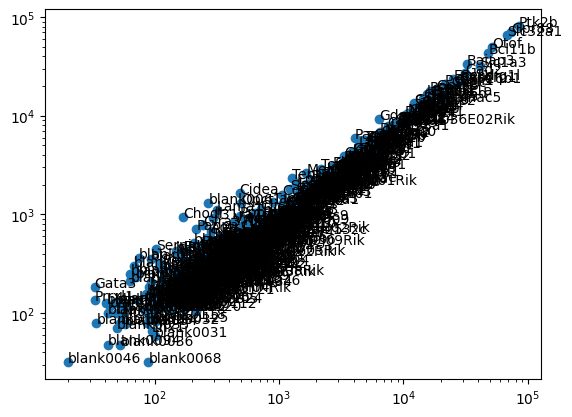

In [580]:
plt.loglog(cts1,cts2,'o')
for gn,ct1,ct2 in zip(gns,cts1,cts2):
    plt.text(ct1,ct2,gn)
    pass

In [581]:
np.sum(dec1.scoreA>dec1.th)>=np.sum(dec2.scoreA>dec2.th)

np.True_

In [582]:
V = plot_multigenes(dec1,['Ptk2b','Kl','Fibcd1'],viewer=None)
V = plot_multigenes(dec2,['Ptk2b','Kl','Fibcd1'],viewer=V)

In [ ]:
Conv_zscan4__231

C:\Users\miket\AppData\Local\Temp\ipykernel_12980\3524677226.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


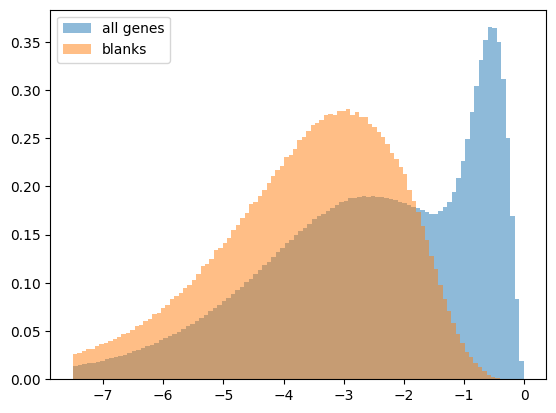

['Zic1', 'Slc1a3', 'Cbln1', 'Slc17a7', 'Grin2c', 'Nfix', 'Slc32a1', 'Syt2', 'Unc13c', 'Reln', 'Pvalb', 'Grm1', 'Caln1', 'Megf11', 'Zfp521', 'Cnr1', 'Whrn', 'Shisa6', 'Chn2', 'Calb2', 'Slc38a1', 'Nfib', 'Sv2b', 'Nos1', 'Ust', 'Scn4b', 'Lhfp', 'Svep1', 'Trhde', 'St18']


C:\Users\miket\AppData\Local\Temp\ipykernel_12980\2242350464.py:529: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  kp = np.in1d(icds,good_igns)


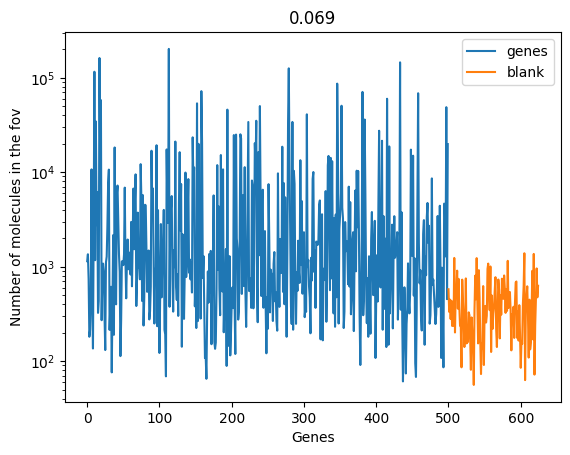

In [489]:
bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()
plt.show()
dec.gns_names=np.array(dec.gns_names)
dec.th=-1.5
plot_statistics(dec)

In [389]:
keep = dec.XH[:,-6]>0.5
XH = dec.XH[keep]
import napari
V = napari.Viewer()
for i in np.arange(9):
    X2d = XH[XH[:,-1]==(3*i+2)][:,1:3]
    V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))
    V.layers[-1].visible=False
#X2d = XH[XH[:,-1]==3*2+2][:,1:3]
#V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

In [390]:
plot_multigenes(
    dec,
    genes=['Reln', 'Sox10'])

Viewer(camera=Camera(center=(0.0, np.float64(1399.5432783961296), np.float64(1407.2974729537964)), zoom=np.float64(0.20394902040021334), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.7126147349675497), stop=np.float64(2798.3739420572915), step=np.float64(1.0)), RangeTuple(start=np.float64(1.4543928702672322), stop=np.float64(2799.7813110351562), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1398.7126147349675), np.float64(1406.4543928702672)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[

In [395]:
code = dec.codes__[list(dec.gns_names).index('Reln')]

In [399]:
keep = dec.XH[:,-6]>0.25
XH = dec.XH[keep]
import napari
V = napari.Viewer()
for ibit in code:
    X2d = XH[XH[:,-1]==ibit][:,1:3]
    V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))
    V.layers[-1].visible=False
#X2d = XH[XH[:,-1]==3*2+2][:,1:3]
#V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

In [403]:
np.array(code)//3+1

array([1, 4, 5, 5])

In [483]:
def get_XH_full(dec,fov='Conv_zscan1__044',ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
               save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits',r'X:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
               
               medH_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz',
                 color_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl',
               master_transf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy',
               dic_pos_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl'):
    dec.ncols = ncols
    dec.sz = sz
    dec.pix_size=pix_size
    dec.fov=fov
    set_ = get_set(fov)
    dec.set_ = set_
    MA = np.load(master_transf)
    
    dec.save_folders = save_folders
    htags = [f'H{iH+1}_MER{set_}' for iH in [4]]
    dic_pos = pickle.load(open(dic_pos_fl,'rb'))
    dec.dic_pos = dic_pos
    fovs = np.array(list(dic_pos.keys()))
    pos  = np.array([dic_pos[fv]for fv in fovs])
    ifov = list(fovs).index(fov)
    
    dists_pix = np.linalg.norm(np.abs((pos[ifov]-pos)/pix_size),axis=-1)
    allneigh = np.where(dists_pix<np.sqrt(2)*sz[-1]*1.25)[0]
    allneigh = allneigh[np.argsort(dists_pix[allneigh])]
    fovs_neigh = fovs[allneigh]
    dec.fovs = fovs
    dec.allneigh = allneigh
    dec.pos = pos
    XH = []
    for iH,htag in enumerate(tqdm(htags)):
        for icol in [2]:#np.arange(ncols):
            Xhs,Xprev,posT_fovs= [],[],[]
            tfov=0
            for ifv in allneigh:
                fv = fovs[ifv]
                X_prev,Xh_prev = [],[]
                fit_fl_prev = ''
                save_folder_prev = ''
                for save_folder in save_folders:
                    fit_fl = save_folder+os.sep+fv+'--'+htag+'--col'+str(icol)+'__Xhfits.npz'
                    ### deal with 
                    
                    if os.path.exists(fit_fl):
                        Xh = np.load(fit_fl,allow_pickle=True)['Xh']
                        X = []
                        if len(Xh.shape):
                            if len(Xh)>0:
                                Xh = Xh[Xh[:,-2]>th_cor]
                                X = Xh[Xh[:,-4]>0.5][:,:3]
                                if save_folder==save_folders[0]:
                                    X0 = X.copy()#apply_colorcor(X,MA).copy()
                        print(len(X),len(X_prev))
                        if len(X)<len(X_prev):
                            X = X_prev
                            Xh = Xh_prev
                            fit_fl_final = fit_fl_prev
                            SAVE_FOLDER = save_folder_prev
                        else:
                            
                            fit_fl_final = fit_fl_prev = fit_fl
                            SAVE_FOLDER = save_folder_prev = save_folder
                            if save_folder!=save_folders[0]:
                                tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus,R = get_best_translation_pointsT(fv,htag,htag,
                                                                                    save_folder,save_folders[0],
                                                                                                     set_=set_,resc=5,th=0,MA=MA,return_rotation=True)
                                #tzxyf
                                
                                Xh[:,:3]+=tzxyf
                                Xh[:,:3] = Xh[:,:3]@R
                            X_prev = X
                            Xh_prev = Xh
                        #X.copy()
                print(fit_fl_final)
                if (iH==0) and (fov==fv):
                    save_folder_ref = save_folders[0]#SAVE_FOLDER
                    htagref = htag
                if (fov==fv):
                    save_folder_dapi = save_folders[0]#SAVE_FOLDER
                if len(Xh.shape):
                    if len(Xh)>0:
                        #print(X0)
                        Xh = Xh[Xh[:,-2]>th_cor]
                        Xh[:,3] = tfov
                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,:3] = apply_colorcor(Xh[:,:3],ms[icol])
                            X0 = apply_colorcor(X0,ms[icol])
                        X = Xh[:,:3]
                        MA = np.load(master_transf)
                        X = apply_colorcor(X,MA)
                        X0 = apply_colorcor(X0,MA)
                        Xh[:,:3]=X
                        X = X[Xh[:,-4]>0.5]
                    
                        pT = pos[allneigh[0]]
                        px,py = (pos[ifv]-pT)/pix_size
                        X = X+[0,px,py]
                        X0 = X0+[0,px,py]
                        tzxy = np.array([0,0,0])
                        if len(Xprev)>0:
                            Xall = np.concatenate(Xprev)
                            try:
                                print("BB",len(X0),len(X))
                                tzxy,ncts = get_best_translation_points(X0,Xall,resc=5,target=3,constr=50,return_counts=True)
                                if np.isnan(tzxy[0]): tzxy = np.array([0,0,0])
                                X0=X0-tzxy
                                X = X-tzxy
                                print(tzxy,ncts)
                            except:
                                pass
                        T = [0,px,py]-tzxy
                        Xh[:,:3]+=T
                        Xprev.append(X0.copy())
                        Xhs.append(Xh)
                        posT_fovs.append(T+np.array(sz)/2)
                        tfov+=1
            dec.Xhs=list(Xhs)
            Xhs = np.concatenate(Xhs)
            if len(Xhs)>0:
                XA = Xhs[:,:3]
                iFOV = Xhs[:,3].astype(int)
                dd,ii = KDTree(posT_fovs).query(XA,p=np.inf,workers=20)
                Xhs = Xhs[ii==iFOV]
                Xh = Xhs
                if len(Xh)>0:
                    
                    ### Calculate drift
                    if len(Xh)>0:
                        tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_best_translation_pointsT(fov,htag,htagref,save_folder_dapi,save_folder_ref,
                                                                                                 set_=set_,resc=5,th=0,MA=MA)
                        print(htag,htagref,save_folder_dapi,save_folder_ref)
                        print("Drift:",tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus)
                        Xh[:,:3]=Xh[:,:3]+tzxyf# drift correction
                        
                        #Xh = Xh[np.all((Xh[:,1:3]<dec.sz[-2:])&(Xh[:,1:3]>=0),axis=-1)]
                        
                        bit = iH*ncols+icol
                        if medH_fl is not None:
                            medHs = np.load(medH_fl)['medHs']
                            Xh[:,-1]=Xh[:,-1]/medHs[bit]
             
                        icolR = np.array([[icol,bit]]*len(Xh))
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.append(XH_)
        
    XH = np.concatenate(XH)
    dec.XH = XH

In [484]:
get_XH_full(dec,fov=dec.fov,ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
               save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits',r'Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
               
               medH_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz',
                 color_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl',
               master_transf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy',
               dic_pos_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

57045 0
72668 57045
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan4__229--H5_MER_set4--col2__Xhfits.npz
76291 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__576--H5_MER_set4--col2__Xhfits.npz
BB 76291 76291
[-2.19575787 14.22860823 65.44570648] 2362
80168 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__254--H5_MER_set4--col2__Xhfits.npz
BB 80168 80168
[  4.58629209  62.40619991 -30.77691002] 994
88000 0
Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits\Conv_zscan4__575--H5_MER_set4--col2__Xhfits.npz
BB 88000 88000
[ -1.2395525  -63.89237958   7.76424624] 2519
10725 0
28681 10725
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan4__230--H5_MER_set4--col2__Xhfits.npz
BB 10725 28681
[  3.63672029 -31.03088914 -64.77647068] 551
44815 0
74767 44815
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan4__228--H5_MER_set4--col2__Xhfits.npz
BB 44815 74767
[-0.3542067  78.7269573  33.99506161] 2190
71728 0
Z:\MERFISHp\12_16_2025_

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.18s/it]


In [485]:

import napari
V = napari.Viewer()
for Xh in dec.Xhs:

    X2d = Xh[Xh[:,-4]>0.5][:,1:3]
    V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

In [374]:
keep = dec.XH[:,-6]>0.5
XH = dec.XH[keep]
import napari
V = napari.Viewer()
for i in np.arange(9):
    X2d = XH[XH[:,-1]==(3*i+1)][:,1:3]
    V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))
    V.layers[-1].visible=False
#X2d = XH[XH[:,-1]==3*2+2][:,1:3]
#V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

In [361]:
scores_ref_fl = save_folder+os.sep+'scores_BRBB_Final_th3.npy'
if not os.path.exists(scores_ref_fl):
    score_ref = np.sort(dec.score,axis=0)
    dec.score_ref = score_ref
    np.save(scores_ref_fl,score_ref)
else:
    dec.score_ref = np.load(scores_ref_fl)
    
set_scoreA(dec)
scoreA = dec.scoreA
keep = dec.scoreA>-3

C:\Users\miket\AppData\Local\Temp\ipykernel_12980\3524677226.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


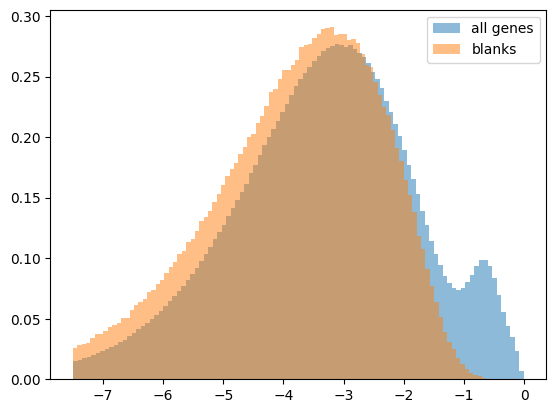

['Gfap', 'Pparg', 'Sox10', 'Nfix', 'Lpar1', 'Slc1a3', 'Zeb2', 'Slc32a1', 'Mog', 'Tbx3', 'Sulf2', 'Pou3f3', 'Opalin', 'Zfp536', 'Ptk2b', 'Unc13c', 'Grm3', 'Gja1', 'Sox2', 'Synpr', 'Lrp4', 'Gpr88', 'Ecel1', 'Pax5', 'Dscaml1', 'Lypd1', 'Bcl11b', 'Rasgrp1', 'Vit', 'Pcp4l1']


C:\Users\miket\AppData\Local\Temp\ipykernel_12980\2837297016.py:494: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  kp = np.in1d(icds,good_igns)


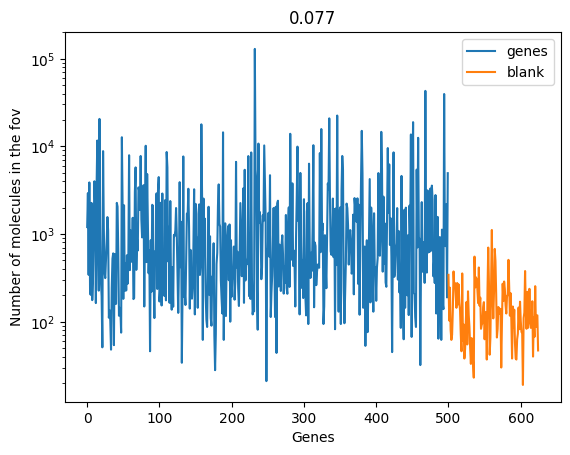

In [362]:
bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()
plt.show()
dec.gns_names=np.array(dec.gns_names)
dec.th=-1.5
plot_statistics(dec)

In [336]:
fov='Conv_zscan1__013'
dec.decoded_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files'+os.sep+f'DecodedNew--{fov}.npz'
scoreA = np.load(dec.decoded_fl)['scoreA']
keep = scoreA>-1.5
XH_pruned = np.load(dec.decoded_fl)['XH_pruned'][keep]
scoreA = np.load(dec.decoded_fl)['scoreA'][keep]
icodesN = np.load(dec.decoded_fl)['icodesN'][keep]


keep =  dec.scoreA>-1.5
XH_pruned_full = dec.XH_pruned[keep]
scoreA_full = dec.scoreA[keep]
icodesN_full = dec.icodesN[keep]


<Points layer 'Points [1]' at 0x284a5c324d0>

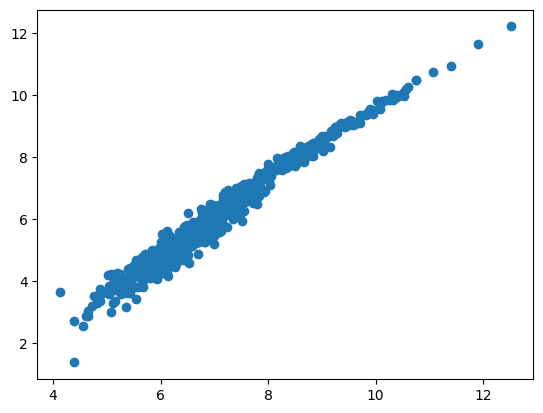

In [354]:
icds,cts = np.unique(icodesN_full,return_counts=True)
dic_full = dict(zip(icds,cts))
icds,cts = np.unique(icodesN,return_counts=True)
dic = dict(zip(icds,cts))

x,y = zip(*[[dic_full.get(icd,0),dic.get(icd,0)] for icd in dic])
plt.scatter(np.log1p(x),np.log1p(y))

In [359]:
np.exp(np.mean(np.log1p(x)-np.log1p(y)))-1

np.float64(1.6177556765110852)

In [340]:
gns,cts = np.unique(dec.gns_names[icodesN_full],return_counts=True)
gns[np.argsort(cts)]

array(['blank0036', 'blank0094', 'blank0099', 'blank0091', 'blank0089',
       'Arhgap15', 'Hoxb3', 'blank0112', 'Gpr149', 'Cbln1', 'Lhx1',
       'blank0046', 'Slc17a8', 'blank0048', 'Kcnj5', 'Klk6', 'Evx2',
       'blank0090', 'Nts', 'blank0031', 'Sox14', 'Dlk1', 'blank0074',
       'blank0042', 'Svep1', 'Lhx9', 'Ttc6', 'Irs4', 'blank0103', 'Oprk1',
       'Apela', 'blank0062', 'blank0119', 'Rxfp1', 'blank0096',
       'blank0068', 'Vsx2', 'blank0072', 'blank0097', 'Slc6a4',
       '9330158H04Rik', 'Prlr', 'blank0027', 'blank0125', 'blank0058',
       'D130009I18Rik', 'Ror1', 'blank0018', 'Adamts19', 'Nhlh2',
       'blank0076', 'Hoxb5', 'blank0102', 'blank0005', 'blank0088',
       'Hs3st3b1', 'Osr1', 'blank0039', 'blank0037', 'Drd2', 'Pax7',
       'blank0093', 'blank0034', 'Pdgfd', 'blank0098', 'blank0060',
       'Ndst4', 'Spin2c', 'Syndig1l', 'Drd5', 'blank0024', 'Eomes',
       'Ptger3', 'blank0092', 'Trhr', 'blank0117', 'blank0082', 'Cd36',
       'Ttc29', 'blank0083', 'blank0

In [349]:
gene = 'Slc30a3'
keep_gn = dec.gns_names[icodesN]==gene
keep_gn_full = dec.gns_names[icodesN_full]==gene


import napari
V = napari.Viewer()
V.add_points(np.nanmean(XH_pruned_full,axis=1)[keep_gn_full][:,1:3],size=5,face_color='g',border_width=0)
V.add_points(np.nanmean(XH_pruned,axis=1)[keep_gn][:,1:3],size=5,face_color='r',border_width=0)

<Points layer 'Points [1]' at 0x28674481720>

C:\Users\miket\AppData\Local\Temp\ipykernel_12980\3524677226.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


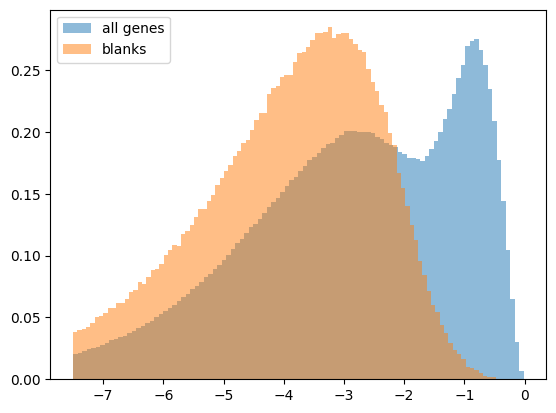

['Slc17a7', 'Ptk2b', 'Slc1a3', 'Nfix', 'Lhx2', 'Sv2b', 'Slc30a3', 'Kcnk9', 'Grm3', 'Ccn3', 'Nptx2', 'Nr2f1', 'Lamp5', 'Slit3', 'Cacng3', 'Epha4', 'Syt17', 'Caln1', 'Otof', 'Rgs4', 'Gpr88', 'Rasgrp1', 'Sorcs3', 'Chrm3', 'Fosl2', 'Rgs6', 'Pou3f3', 'Cxcl14', 'Serpine2', 'Zeb2']


C:\Users\miket\AppData\Local\Temp\ipykernel_12980\2837297016.py:494: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  kp = np.in1d(icds,good_igns)


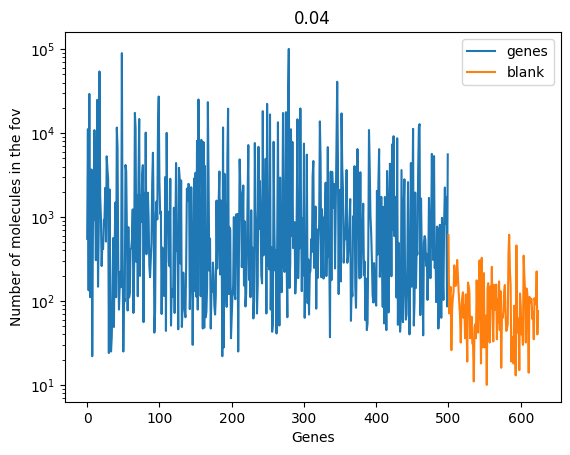

In [327]:
bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()
plt.show()
dec.gns_names=np.array(dec.gns_names)
dec.th=-1.5
plot_statistics(dec)

In [322]:
plot_multigenes(dec,genes=['Slc17a7',
                           'Slit3','Gja1', 'Slc1a3','Gad2','Lamp5','Megf11','Igfbpl1'])

Viewer(camera=Camera(center=(0.0, np.float64(1400.663570736845), np.float64(1399.3989555357643)), zoom=np.float64(0.20298500252765073), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.3403667062520981), stop=np.float64(2799.7443033854165), step=np.float64(1.0)), RangeTuple(start=np.float64(0.3119084673623244), stop=np.float64(2799.6160481770835), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1400.340366706252), np.float64(1399.3119084673624)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[<P

In [293]:
X2d = np.nanmean(dec.XH_pruned[dec.scoreA>-1.5],axis=1)[:,1:3]

In [294]:
napari.view_points(X2d,face_color='w',border_width=0,size=2)

C:\Users\miket\AppData\Local\Temp\ipykernel_12980\18637371.py:1: FutureWarning: `napari.view_points` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_points(...)` instead.
  napari.view_points(X2d,face_color='w',border_width=0,size=2)


Viewer(camera=Camera(center=(0.0, np.float64(1399.9953178620585), np.float64(1400.0944089591503)), zoom=np.float64(0.20345866126414547), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.10123142724235852), stop=np.float64(2799.889404296875), step=np.float64(1.0)), RangeTuple(start=np.float64(0.31845659017562866), stop=np.float64(2799.870361328125), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1399.1012314272423), np.float64(1399.3184565901756)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[

In [268]:
all_fls = glob.glob(r'Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\*--col2__Xhfits.npz')
check_fls = []
for fl_new in tqdm(all_fls):
    fov = get_fov(fl_new)
    htag = os.path.basename(fl_new).split('--')[1]
    fl_old = fl_new.replace('BigSlideTestV2','BigSlideTest')
    XhN = np.load(fl_new)['Xh']
    NN = np.sum(XhN[:,-4]>0.5)
    icol = int(fl_new.split('--col')[-1].split('_')[0])
    XhO = np.load(fl_old)['Xh']
    NO = np.sum(XhO[:,-4]>0.5)
    if NN>NO: 
        pass
        #print('new is better')
    else:
        print('old is better')
        print(fl_new)
        if icol==2:
            check_fls.append(fl_new)

  0%|▏                                                                                | 7/2977 [00:01<08:48,  5.62it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__555--H4_MER_set5--col2__Xhfits.npz


  0%|▎                                                                               | 13/2977 [00:02<10:08,  4.87it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan6__819--H5_MER_set6--col2__Xhfits.npz


  1%|▊                                                                               | 28/2977 [00:06<12:49,  3.83it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan10__436--H3_MER_set10--col2__Xhfits.npz


  2%|█▊                                                                              | 67/2977 [00:15<08:26,  5.74it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan4__123--H4_MER_set4--col2__Xhfits.npz


  2%|█▉                                                                              | 71/2977 [00:16<11:02,  4.39it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__105--H7_MER_set5--col2__Xhfits.npz


  3%|██                                                                              | 78/2977 [00:17<09:00,  5.36it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan3__286--H5_MER_set3--col2__Xhfits.npz


  3%|██▎                                                                             | 84/2977 [00:18<11:28,  4.20it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan7__202--H7_MER_set7--col2__Xhfits.npz


  3%|██▍                                                                             | 92/2977 [00:21<17:52,  2.69it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__717--H7_MER_set5--col2__Xhfits.npz


  3%|██▌                                                                             | 97/2977 [00:23<15:40,  3.06it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan3__267--H5_MER_set3--col2__Xhfits.npz


  5%|███▋                                                                           | 141/2977 [00:39<16:51,  2.80it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan3__194--H7_MER_set3--col2__Xhfits.npz


  5%|███▊                                                                           | 143/2977 [00:40<16:24,  2.88it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__366--H4_MER_set5--col2__Xhfits.npz


  5%|███▊                                                                           | 144/2977 [00:40<17:13,  2.74it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan8__119--H4_MER_set8--col2__Xhfits.npz


  5%|████▏                                                                          | 158/2977 [00:46<17:40,  2.66it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__070--H7_MER_set5--col2__Xhfits.npz


  6%|████▍                                                                          | 169/2977 [00:50<18:05,  2.59it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan10__017--H6_MER_set10--col2__Xhfits.npz


  6%|████▊                                                                          | 179/2977 [00:54<18:31,  2.52it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__168--H2_MER_set5--col2__Xhfits.npz


  6%|████▉                                                                          | 187/2977 [00:57<17:04,  2.72it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan6__733--H5_MER_set6--col2__Xhfits.npz


  8%|██████▎                                                                        | 237/2977 [01:16<15:11,  3.01it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan7__627--H7_MER_set7--col2__Xhfits.npz


  9%|███████                                                                        | 266/2977 [01:26<13:00,  3.48it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan5__427--H5_MER_set5--col2__Xhfits.npz


 10%|███████▊                                                                       | 294/2977 [01:37<15:29,  2.89it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan6__183--H6_MER_set6--col2__Xhfits.npz


 11%|████████▌                                                                      | 321/2977 [01:46<15:25,  2.87it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan6__179--H7_MER_set6--col2__Xhfits.npz


 11%|████████▌                                                                      | 322/2977 [01:47<16:16,  2.72it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan7__319--H6_MER_set7--col2__Xhfits.npz


 11%|████████▌                                                                      | 323/2977 [01:47<15:24,  2.87it/s]

old is better
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan7__495--H6_MER_set7--col2__Xhfits.npz


 11%|████████▉                                                                      | 335/2977 [01:52<14:44,  2.99it/s]


KeyboardInterrupt: 

In [256]:
icol

2

In [280]:

fl_new = r'Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan3__366--H2_MER_set3--col2__Xhfits.npz'
#fl_new = check_fls[-6]
#fl_new = r'Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan1__007--H7_MER_set1--col2__Xhfits.npz'
fov = get_fov(fl_new)
icol = int(fl_new.split('--col')[-1].split('_')[0])
htag = os.path.basename(fl_new).split('--')[1]
fl_old = fl_new.replace('BigSlideTestV2','BigSlideTest')
XhN = np.load(fl_new)['Xh']
NN = np.sum(XhN[:,-4]>0.5)

XhO = np.load(fl_old)['Xh']
NO = np.sum(XhO[:,-4]>0.5)
print(NO,NN)
if NN>NO: 
    print('new is better')
else:
    print('old is better')
XhN = XhN[XhN[:,-4]>0.5]
XhO = XhO[XhO[:,-4]>0.5]
np.median(XhO[:,-1]),np.median(XhN[:,-1])

import napari
V = napari.Viewer()
new = read_im(rf'Z:\MERFISHp\12_16_2025_BigSlideTestV2\{htag}\{fov}.zarr')
V.add_image(new[icol],name='new')
old = read_im(rf'Z:\MERFISHp\12_16_2025_BigSlideTest\{htag}\{fov}.zarr')
V.add_image(old[icol],name='old')

53371 122427
new is better


<Image layer 'old' at 0x27fedfe24d0>

<Image layer 'old' at 0x27607cc3b20>

In [281]:
save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits',r'Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits']
htag = 'H2_MER_set3'
fv = 'Conv_zscan3__366'
icol=2
X = []
X_prev,Xh_prev = [],[]
fit_fl_prev = ''
save_folder_prev = ''
for save_folder in save_folders:
    fit_fl = save_folder+os.sep+fv+'--'+htag+'--col'+str(icol)+'__Xhfits.npz'
    ### deal with 
    
    
    if os.path.exists(fit_fl):
        Xh = np.load(fit_fl,allow_pickle=True)['Xh']
        
        if len(Xh.shape):
            if len(Xh)>0:
                X = Xh[Xh[:,-4]>0.5][:,:3]
        print(len(X),len(X_prev))
        if len(X)<len(X_prev):
            X = X_prev
            Xh = Xh_prev
            fit_fl_final = fit_fl_prev
            SAVE_FOLDER = save_folder_prev
            print('here')
        else:
            X_prev = X
            Xh_prev = Xh
            fit_fl_final = fit_fl_prev = fit_fl
            SAVE_FOLDER = save_folder_prev = save_folder
print(fit_fl_final)

53371 0
122427 53371
Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits\Conv_zscan3__366--H2_MER_set3--col2__Xhfits.npz


In [184]:
len(Xh_prev)

51

In [186]:
save_folder_prev

'Z:\\MERFISHp\\12_16_2025_BigSlideTestV2\\mermake_fits'

In [161]:
plot_multigenes(dec,genes=['Slc17a7',
                           'Slit3','Gja1', 'Slc1a3','Gad2','Lamp5','Megf11','Igfbpl1'])

Viewer(camera=Camera(center=(0.0, np.float64(1400.1929212237396), np.float64(1401.622166713079)), zoom=np.float64(0.2031242881693929), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(0.4556913872559865), stop=np.float64(2799.8451334635415), step=np.float64(1.0)), RangeTuple(start=np.float64(0.33489615470170975), stop=np.float64(2799.7959798177085), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1399.540708983938), np.float64(1401.3348961547017)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[<P

In [292]:
keep = dec.XH[:,-6]>0.5
XH = dec.XH[keep]
import napari
V = napari.Viewer()
for i in np.arange(9):
    X2d = XH[XH[:,-1]==(3*i+2)][:,1:3]
    V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))
    V.layers[-1].visible=False
#X2d = XH[XH[:,-1]==3*2+2][:,1:3]
#V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

In [67]:
keep = dec.XH[:,-6]>0.5
XH = dec.XH[keep]
X2d = XH[XH[:,-1]==0][:,1:3]

In [69]:

import napari
V = napari.Viewer()
X2d = XH[XH[:,-1]==0][:,1:3]
V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))
X2d = XH[XH[:,-1]==9][:,1:3]
V.add_points(X2d,size=5,border_width=0,face_color=np.random.random(3))

<Points layer 'X2d [1]' at 0x27a273dd150>

In [46]:
dec.XH  = np.array(dec.XH )

In [49]:
dec.dec.sz[-2:]

[2800, 2800]